# Time Series Analysis of TESS
This time series analysis of TESS data was an attempt at measuring the rotation period of the M-type star GJ 3942.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle
import lightkurve as lk
from scipy.optimize import minimize_scalar
from scipy.signal import find_peaks
from scipy.optimize import Bounds

## Rotation Period
Our rotation period used is that of a best-fit frequency, while the recorded rotation period is 16.3 days. This can be found in the reference paper. Within this time series analysis, a best-fit frequency of 15.645898033750315 was found and used. This is best in aligning the average TESS photometry peaks with the harmonics, which can be seen later in this notebook. The fonts for plots are also stated here.

Reference Paper: [HADES RV Programme with HARPS-N at TNG VI](https://arxiv.org/pdf/1709.06851.pdf)

In [2]:
rp = 15.7
title_font = 18
label_font = 14
tick_font = 12

## Functions

Functions were created for:
- processing MAST files
- plotting MAST files as scatter plots
- finding even harmonics
- plotting Lombs-Scargle periodograms
- calculating harmonics for each MAST file
- Convert MAST files into arrays
- Generate a matrix out of arrays of MAST files
- Plot an average of these periodogram arrays.

### MAST Files
Seven MAST files were used from seven sectors from TESS. These secotrs had exposure lengths of 20 s and 120 s in pairs of two, that each were taken on five different days, with MAST7 being the the only sector taken on that data.

In [114]:
MAST1 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1207/TESS/tess2020078014623-s0023-0000000162494287-0177-s/tess2020078014623-s0023-0000000162494287-0177-s_lc.fits"
MAST2 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209/TESS/tess2022112184951-s0051-0000000162494287-0223-s/tess2022112184951-s0051-0000000162494287-0223-s_lc.fits"
MAST3 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-2/TESS/tess2022085151738-s0050-0000000162494287-0222-s/tess2022085151738-s0050-0000000162494287-0222-s_lc.fits"
MAST4 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-3/TESS/tess2022138205153-s0052-0000000162494287-0224-s/tess2022138205153-s0052-0000000162494287-0224-s_lc.fits"
MAST5 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-4/TESS/tess2022112184951-s0051-0000000162494287-0223-a_fast/tess2022112184951-s0051-0000000162494287-0223-a_fast-lc.fits"
MAST6 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-5/TESS/tess2022138205153-s0052-0000000162494287-0224-a_fast/tess2022138205153-s0052-0000000162494287-0224-a_fast-lc.fits"
MAST7 = "/Users/andrewandmatthewfonseca/Downloads/MAST_2024-03-13T1209-6/TESS/tess2022085151738-s0050-0000000162494287-0222-a_fast/tess2022085151738-s0050-0000000162494287-0222-a_fast-lc.fits"
mast_files = [MAST1, MAST2, MAST3, MAST4, MAST5, MAST6, MAST7]

### Proccessing MAST Files

This function is to process MAST files by grabbing relevant data fields, such as time, flux, and resolution. We also remove any NaN values and sigma clip to remove outliers caused by flares, which can bias the periodogram at high frequencies.

In [115]:
#For processsing MAST files to find information (includes sigma clipping)
def process_MAST_file(mast_file_path):
    fits_data = fits.open(mast_file_path)
    data = fits_data[1].data
    time = data.field('TIME')
    pdcsap_flux = data.field('PDCSAP_FLUX')
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    #print(resolution)
    
    #Remove NaN values
    indices = np.where(~np.isnan(pdcsap_flux))[0]
    time = time[indices]
    pdcsap_flux = pdcsap_flux[indices]
    
    #Remove outliers (Sigma Clipping)
    std_dev = np.std(pdcsap_flux)
    good_data = np.where(np.abs(pdcsap_flux - np.mean(pdcsap_flux)) < 3 * std_dev)[0]
    time = time[good_data]
    pdcsap_flux = pdcsap_flux[good_data]
    
    return time, pdcsap_flux

### Plotting MAST Files

Here we create scatter plots from the MAST files. With these scatter plots, we can see the presence of a signal. 

In [209]:
#Plotting MAST files as scatter plots
def plot_MAST_file(mast_file_path, sector_num):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    plt.figure(figsize=(9, 5))
    plt.scatter(time, pdcsap_flux, alpha=0.1, color='royalblue', marker='.')
    plt.title(f'TESS Sector {sector_num} Scatter Plot', fontsize=title_font)
    plt.xlabel('Time (Days)', fontsize=label_font)
    plt.ylabel(r"PDCSAP-Flux (e- s$^{-1}$)", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.show()

### Harmonics (not even harmonics)

We create even harmonics of the 16-day rotation signal to apply to the Lomb-Scargle periodogram, as well as create an array of harmonics. We then apply this array to the avearged periodogram (TESS Photometry) later on. We also shade a resolution margin on other side of the harmonics.

In [139]:
#For showing any (even?) harmonics of the 32-day (?) period in the data, as well as resolution margin.
def even_harmonics(num, mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    time_baseline = time[-1] - time[0]
    resolution = 1 / time_baseline
    for i in np.arange(1, num+1, 1):
        x = i/rp # 16 day frequency
        plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
        plt.fill_between([x - resolution, x + resolution], [1, 1], [1e9, 1e9], color='lightgray', alpha=0.3)

### Even Harmonics Array

This is the array that we used the previous function for. This will be applyed solely to the TESS Photometry plot. This function is needed to capture multiple frequnices and serve as a complete representation of the signal's behavior for use in the averaged periodogram.

In [119]:
# Array of all MAST files (for average periodogram)
def even_harmonics_array(num, mast_file_paths):
    for mast_file_path in mast_file_paths:
        time, pdcsap_flux = process_MAST_file(mast_file_path)
        time_baseline = time[-1] - time[0]
        resolution = 1 / time_baseline
        for i in np.arange(1, num+1, 1):
            x = i/rp
            plt.axvline(x=x, color='k', linestyle='--', linewidth=0.5)
            plt.fill_between([x - resolution, x + resolution], [1, 1], [1e8, 1e8], color='gray', alpha=0.03)


### Lomb-Scargle Periodogram

These Lomb-Scargle periodograms are used for characterizing periodic signals in unevenly spaced or irregularly timed data. We also used the even_harmonics function here to view harmonics of the 16-day signal.

In [214]:
#Plotting Lomb-Scargle Periodograms as semilog on y-axis plot.
def plot_lomb_scargle(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    plt.semilogy(frequency, power, linewidth=2, color='royalblue')
    plt.title('Lomg-Scargle Periodogram', fontsize=title_font)
    plt.xlabel('Frequency (cycle per day)', fontsize=label_font)
    plt.ylabel(r"Power (e-$^{2}$ s$^{-2}$ day)", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.xlim(0, 1)
    plt.ylim(1e2, 1e9)
    even_harmonics(16.3, mast_file_path)
    plt.show()

### Calculating Frequency (rename)

Unlike the even_harmonics function, we use this function to get the maximum frequnecy, fundamental harmonics and beyond, and the maximum period of each MAST file. These are printed out in the 'Plots' section for each MAST file.

In [121]:
def calculate_harmonic(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    frequency, power = LombScargle(time, pdcsap_flux, normalization="psd").autopower(nyquist_factor=1)
    max_index = np.argmax(power)
    max_frequency = frequency[max_index]
    max_period = 1 / max_frequency
    harmonic_plus_one = rp / max_period # = 1 -> fundamental harmonic; = 2 -> 1rd harmonic; = 3 -> 2nd harmonic, etc.
    return max_frequency, harmonic_plus_one, max_period

### Periodogram Array

Similar to the even_harmonics_array, this is solely used for setting all of the MAST periodograms into a single array to then be averaged and displayed as the plot called 'TESS Photometry'.

In [1]:
def generate_periodogram_array(mast_file_path):
    time, pdcsap_flux = process_MAST_file(mast_file_path)
    f_grid = np.linspace(0, 0.5, num=1024)
    periodogram = LombScargle(time, pdcsap_flux, normalization="psd").power(f_grid)
    return periodogram

### Periodogram Matrix

This is simply to convert the periodogram array into a matrix to then be displayed in the plotting function for the average periodogram.

In [123]:
def generate_periodogram_matrix(mast_files):
    periodogram_matrix = []
    for mast_file_path in mast_files:
        periodogram = generate_periodogram_array(mast_file_path)
        periodogram_matrix.append(periodogram)
    return np.column_stack(periodogram_matrix)

### Average Peirodogram

This average periodogram of the TESS data shows peaks at the even harmonics for the 16-day signal, giving significance to that 16-day signal.

In [245]:
def plot_average_periodogram(periodogram_array, mast_files):
    f_grid = np.linspace(0, 0.5, num=1024)
    average_periodogram = np.mean(periodogram_array, axis=1)
    plt.figure(figsize=(9, 5))
    plt.semilogy(f_grid, average_periodogram, color='royalblue', linewidth=2)
    plt.title("TESS Photometry", fontsize=title_font)
    plt.xlabel('Frequency (cycles per day)', fontsize=label_font)
    plt.ylabel(r"Power $[(e^{-}/s)^2 \; \operatorname{day}]$", fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.xlim(0, 0.5)
    plt.ylim(1e6, 1e8)
    even_harmonics_array(16.3, mast_files)
    #old_even_harmonics(16)
    plt.show()

# Plots

Here we use all of the above functions to create plots to characterize signals within the TESS data. The first seven are of the different sectors, and then there is the average periodogram called 'TESS Photometry'.

## TESS GJ 3942 Data 1

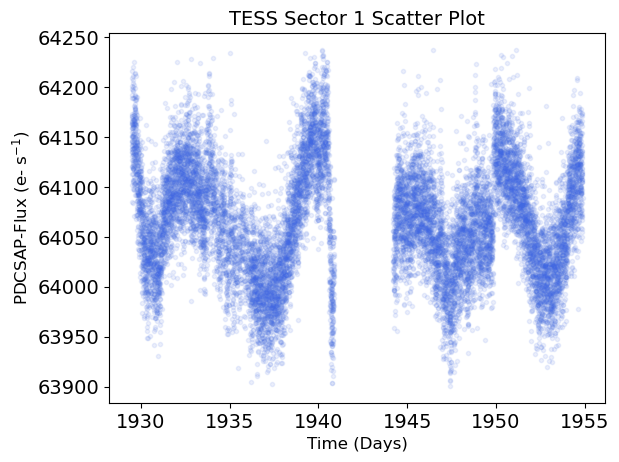

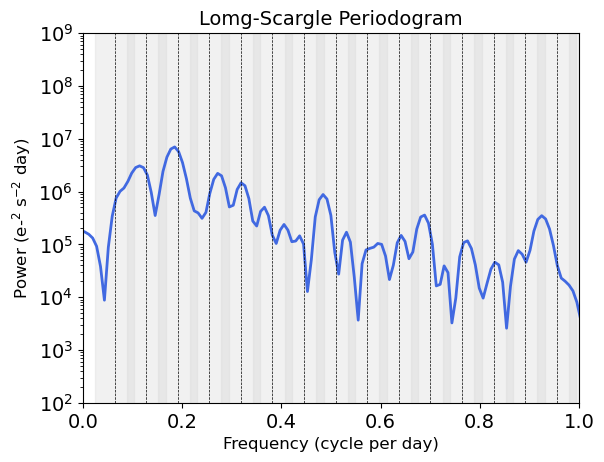

(0.18498682876210162, 2.9042932115649953, 5.405790275404033)

In [145]:
plot_MAST_file(MAST1, 1)
plot_lomb_scargle(MAST1)
calculate_harmonic(MAST1)

## TESS GJ 3942 Data 2

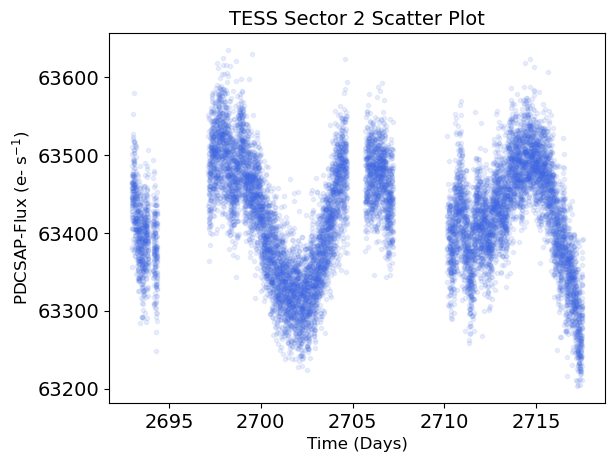

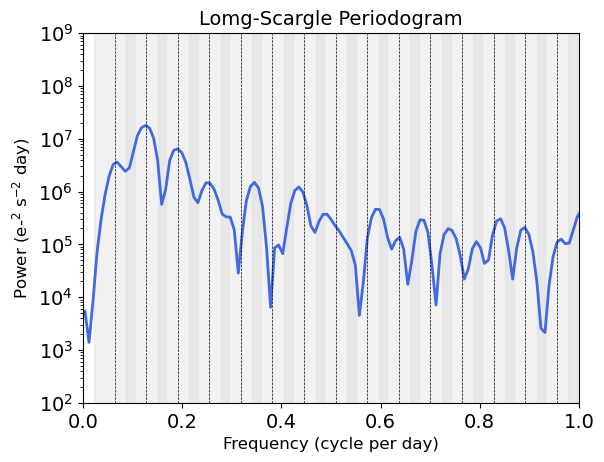

(0.12610260958127134, 1.97981097042596, 7.930050007058055)

In [146]:
plot_MAST_file(MAST2, 2)
plot_lomb_scargle(MAST2)
calculate_harmonic(MAST2)

## TESS GJ 3942 Data 3

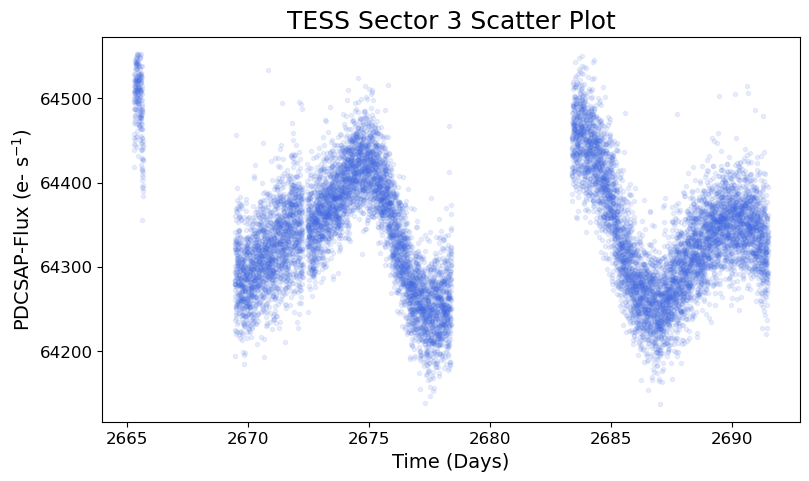

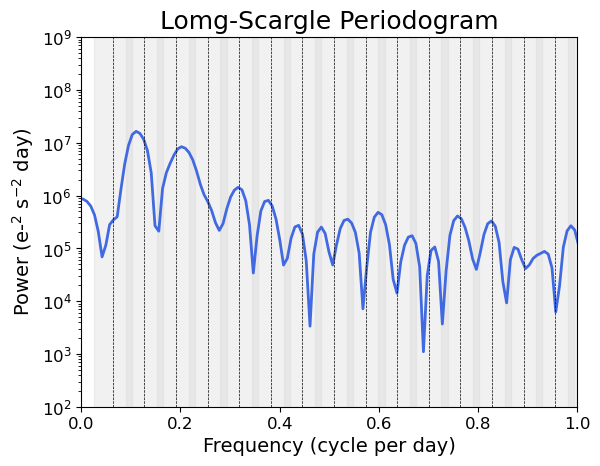

(0.11052801307477737, 1.7352898052740047, 9.04748011097832)

In [248]:
plot_MAST_file(MAST3, 3)
plot_lomb_scargle(MAST3)
calculate_harmonic(MAST3)

## TESS GJ 3942 Data 4

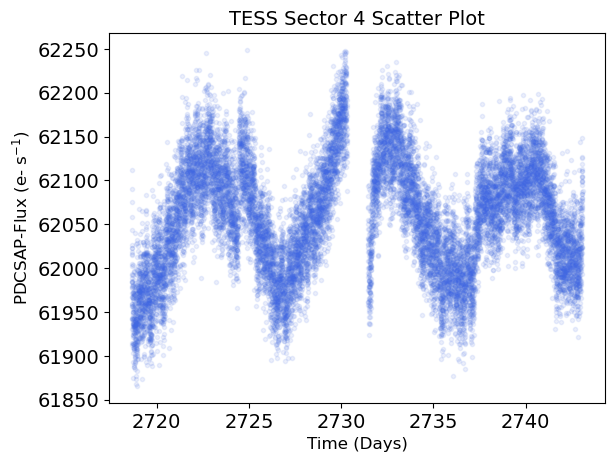

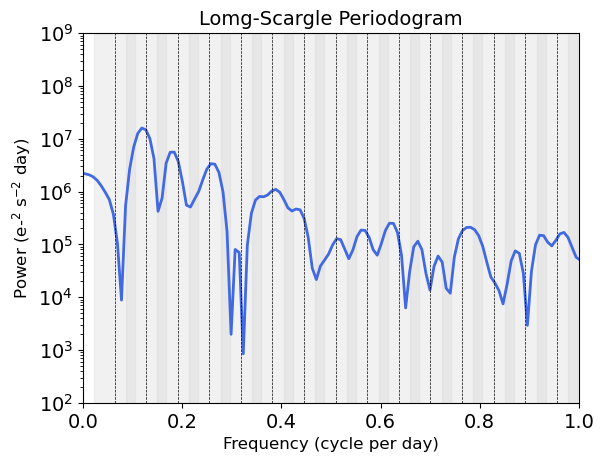

(0.11865894226140021, 1.8629453935039832, 8.427514866911975)

In [148]:
plot_MAST_file(MAST4, 4)
plot_lomb_scargle(MAST4)
calculate_harmonic(MAST4)

## TESS GJ 3942 Data 5

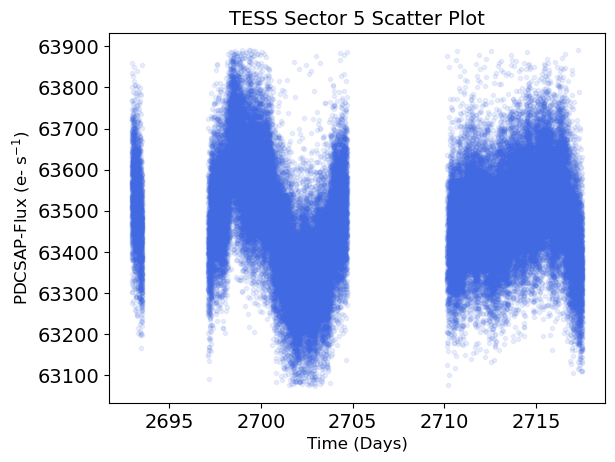

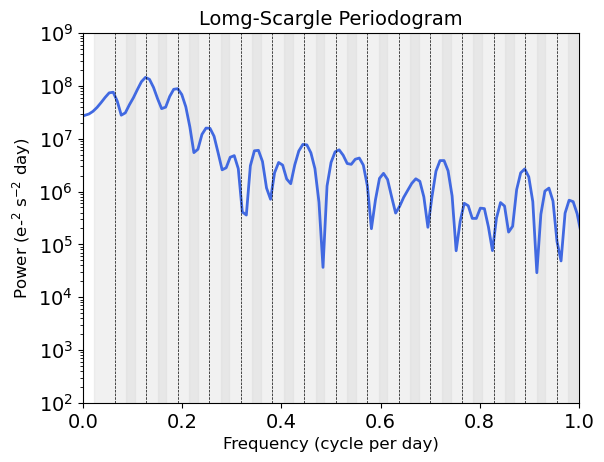

(0.12608005289779825, 1.9794568304954323, 7.931468753511787)

In [149]:
plot_MAST_file(MAST5, 5)
plot_lomb_scargle(MAST5)
calculate_harmonic(MAST5)

## TESS GJ 3942 Data 6

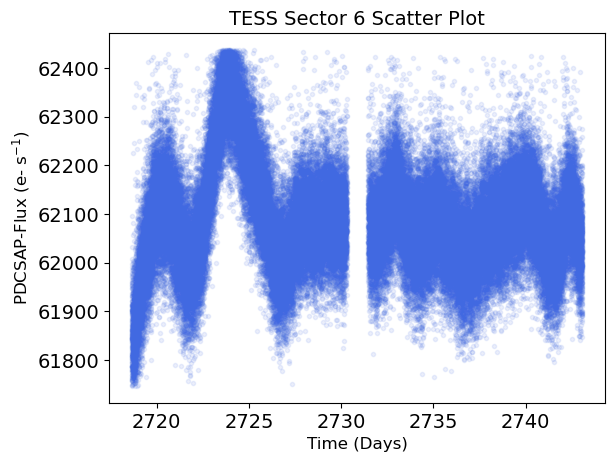

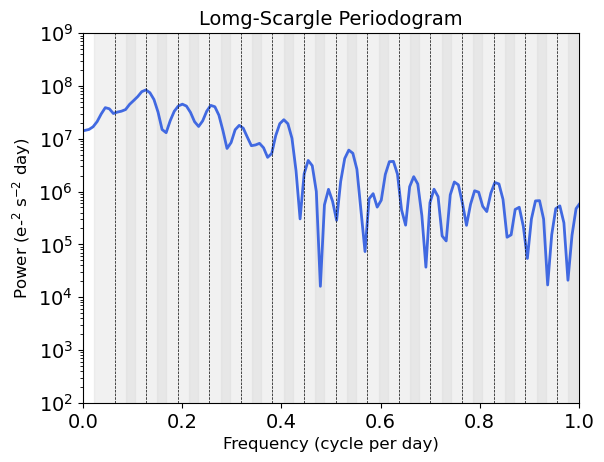

(0.12683390863007146, 1.991292365492122, 7.884326918573782)

In [150]:
plot_MAST_file(MAST6, 6)
plot_lomb_scargle(MAST6)
calculate_harmonic(MAST6)

## TESS GJ 3942 Data 7

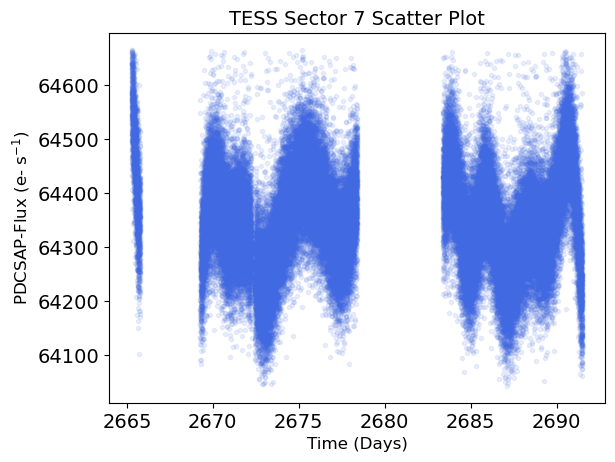

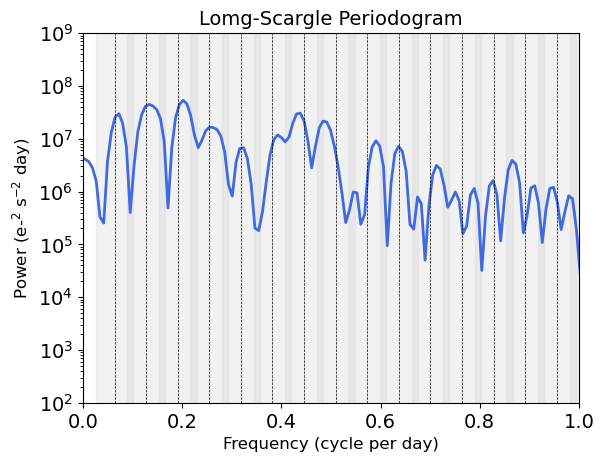

(0.20198343418724568, 3.171139916739757, 4.950901067822053)

In [151]:
plot_MAST_file(MAST7, 7)
plot_lomb_scargle(MAST7)
calculate_harmonic(MAST7)

## Average Lomb-Scargle Periodogram

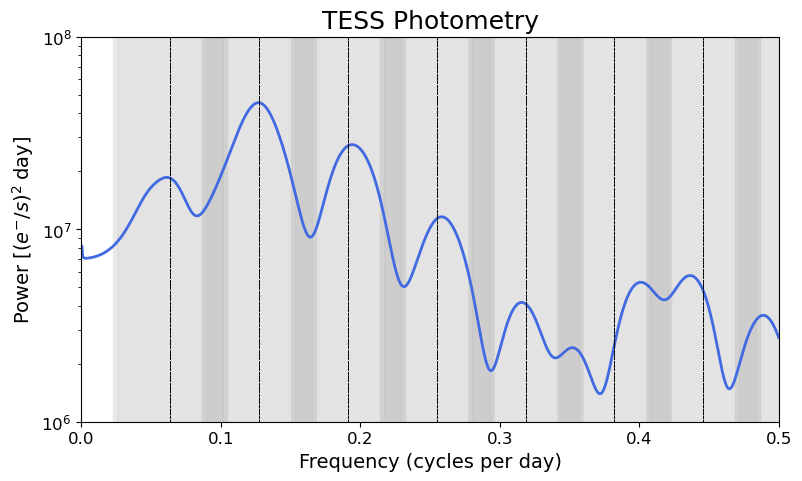

In [249]:
periodogram_array = generate_periodogram_matrix(mast_files)
plot_average_periodogram(periodogram_array, mast_files)
# decresased rp from 16.29 so the harmonics array best fits the peaks in the average periodogram for the TESS data.
# To find the value of the peaks, take the first deriviative,.
# in the message, p is the periodogram
# For minimize, use bounds fo 14.5 and 17.5
# could pass peaks into args for minimize; could hard-code it so wouldnt have to

In [153]:
# Change plot image dimensions (try 9 by 5 for all plots); Change y-axis font size (check other plots font size)
# Add scatter plot of any sector to show a presence of a signal within the TESS data; add plot to empty space in mutlirow. (Using Sector 3 scatter plot)
# Add discussion of resolusion; create summary of Rayleigh resolution paper.

# Best Fit Frequency (1st iteration)

Using the TESS data, we try and find a best-fit frequency by using the first derivative from the averaged periodogram made by the TESS photometry.

In [154]:
def calculate_first_derivative(periodogram, delta_f):
    N = len(periodogram)
    first_derivative = np.zeros(N)
    
    for i in range(1, N-1):
        first_derivative[i] = (periodogram[i+1] - periodogram[i-1]) / (2 * delta_f)
        
    return first_derivative

In [155]:
def find_local_minima(f_grid, derivative): # local minima without find_peaks
    abs_derivative = np.abs(derivative)
    
    # Final local minima where the absolute value of the derivative is closest to zero
    local_minima = np.where((abs_derivative[:-2] > abs_derivative[1:-1]) &
                            (abs_derivative[1:-1] < abs_derivative[2:]))[0] + 1
    
    return local_minima

In [232]:
def plot_first_derivative(f_grid, first_derivative, local_minima):
    plt.figure(figsize=(9, 5))
    plt.plot(f_grid, np.abs(first_derivative))
    plt.scatter(f_grid[local_minima], np.abs(first_derivative)[local_minima], color='red', label='Local Minima')
    plt.title("1st Derivative of TESS Photometry", fontsize=title_font)
    plt.xlabel('Frequency (cycles per day)', fontsize=label_font)
    plt.ylabel('Absolute Value of 1st Derivative', fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.legend()
    plt.show()

In [233]:
def find_optimal_frequency(f_grid, periodogram):
    delta_f = f_grid[1] - f_grid[0]
    first_derivative = calculate_first_derivative(periodogram, delta_f)
    local_minima = find_local_minima(f_grid, first_derivative)
    return f_grid[local_minima]

In [234]:
def objective_function(frequency, f_grid, periodogram):
    # Using a model periodogram
    model_periodogram = np.sin(2 * np.pi * frequency * f_grid)
    return np.sum((periodogram - model_periodogram) ** 2)

In [235]:
def find_best_fit_frequency(f_grid, periodogram):
    result = minimize_scalar(objective_function, args=(f_grid, periodogram), bounds=(14.5, 17.5), method='bounded')
    return result.x

In [236]:
periodogram_array = generate_periodogram_matrix(mast_files)
f_grid = np.linspace(0, 0.5, num=1024)
average_periodogram = np.mean(periodogram_array, axis=1)

In [239]:
delta_f = f_grid[1] - f_grid[0]
first_derivative = calculate_first_derivative(average_periodogram, delta_f)
local_minima = find_local_minima(f_grid, first_derivative)

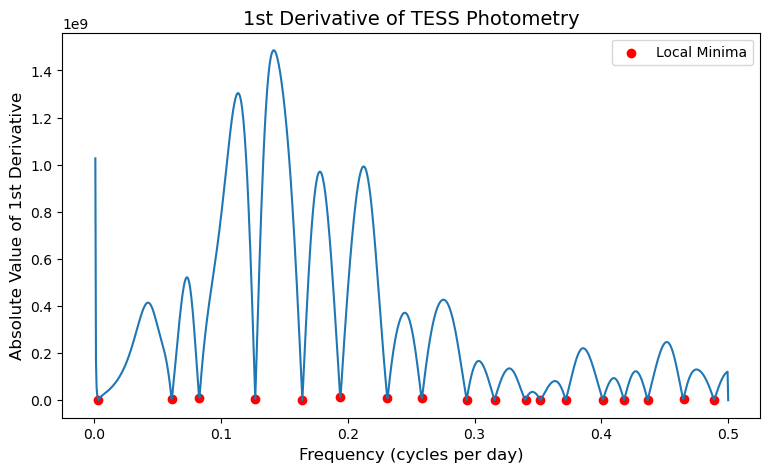

In [240]:
plot_first_derivative(f_grid, first_derivative, local_minima)

In [163]:
best_frequency = find_best_fit_frequency(f_grid, average_periodogram)
print("Best Fit Frequency: ", best_frequency)

Best Fit Frequency:  15.645898033750315


# Best Fit Frequency (2nd iteration) (poor implementation; abandoned)

In [169]:
def calculate_derivative(average_periodogram, delta_f):
    derivative = (average_periodogram[2:] - average_periodogram[:-2]) / (2 * delta_f)
    return derivative

In [170]:
def find_zero_derivative_points(derivative, f_grid):
    # Local minima in the absolute value of the derivative
    minima_indices, _ = find_peaks(-np.abs(derivative))
    # Corresponding frequencies where the minima occur
    minima_frequencies = f_grid[1:-1][minima_indices]    
    return minima_frequencies

In [218]:
def plot_derivative(derivative, f_grid):
    plt.figure(figsize=(9, 5))
    plt.plot(f_grid[1:-1], np.abs(derivative), color='blue', linewidth=2)
    plt.title('Derivative of Average Periodogram', fontsize=title_font)
    plt.xlabel('Frequency (cycles per day)', fontsize=label_font)
    plt.ylabel('Absolute Value of First Derivative', fontsize=label_font)
    plt.tick_params(axis='both', which='major', labelsize=tick_font)
    plt.grid(True)
    plt.show()

In [219]:
def analyze_peaks(f_grid, minima_frequencies):
    print("Frequencies where the derivative is close to zero: ")
    
    if len(minima_frequencies) > 0:
        for freq in minima_frequencies:
            print(f"Frequency: {freq:.6f} cycles per day")
            
    else:
        print("No frequencies found close to zero derivative.")

In [220]:
def objective_function(f_r, peak_frequencies):
    # Sum of remainders from peak frequencies divided by the guess rotation frequency (f_r)
    remainders = np.abs(peak_frequencies % f_r)
    return np.sum(remainders)

In [221]:
def find_best_fit_rf(peak_frequencies):
    # Set bounds on f_r (rotation frequency)
    lower_bound, upper_bound = 14.5, 17.5
    # Minimize the objective function
    result = minimize_scalar(objective_function, bounds=(lower_bound, upper_bound), args=(peak_frequencies,), method='bounded')
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed. Try adjusting the bounds for initial guess.")

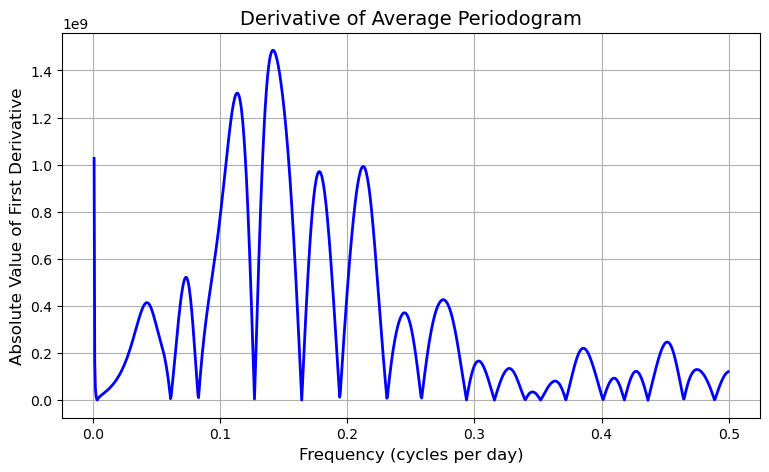

In [222]:
delta_f = f_grid[1] - f_grid[0]
average_periodogram = np.mean(periodogram_array, axis=1)
derivative = calculate_derivative(average_periodogram, delta_f)
plot_derivative(derivative, f_grid)

In [259]:
minima_frequencies = find_zero_derivative_points(derivative, f_grid)
analyze_peaks(f_grid, minima_frequencies)

Frequencies where the derivative is close to zero: 
Frequency: 0.003421 cycles per day
Frequency: 0.061095 cycles per day
Frequency: 0.083089 cycles per day
Frequency: 0.127077 cycles per day
Frequency: 0.164223 cycles per day
Frequency: 0.194037 cycles per day
Frequency: 0.231183 cycles per day
Frequency: 0.258553 cycles per day
Frequency: 0.293744 cycles per day
Frequency: 0.315738 cycles per day
Frequency: 0.340176 cycles per day
Frequency: 0.351906 cycles per day
Frequency: 0.371945 cycles per day
Frequency: 0.401271 cycles per day
Frequency: 0.417889 cycles per day
Frequency: 0.436461 cycles per day
Frequency: 0.464809 cycles per day
Frequency: 0.488759 cycles per day


In [261]:
m = 4 # Change based on number of first m number of minima to account for
best_fit_frequency = find_best_fit_rf(minima_frequencies[:m]) 
print(f"Best-fit rotation frequency: {best_fit_frequency:.6f} cycles per day")

Best-fit rotation frequency: 17.499993 cycles per day


# Stacked Pseudo-Window Plots (didn't include)

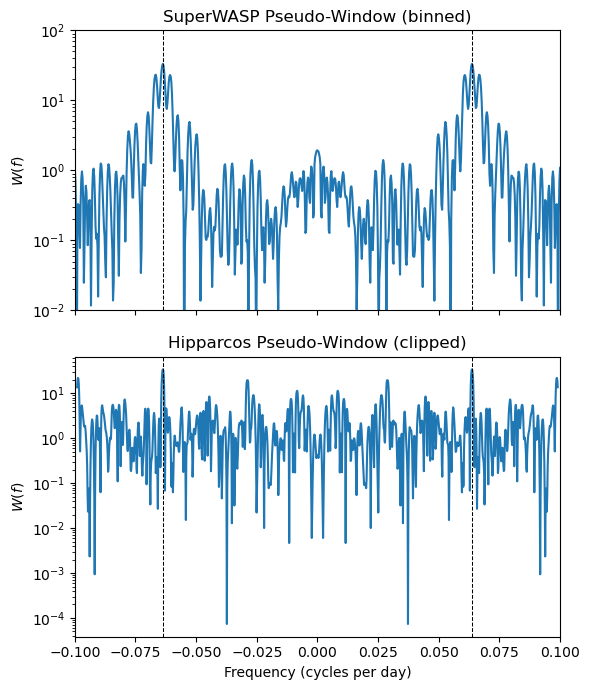

In [270]:
# Figure with stacked pseudo-window plots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 7))


# First plot (SuperWASP)
ax1.set_title("SuperWASP Pseudo-Window (binned)")
ax1.set_ylabel(r"$W(f)$")
freq, specwin = LombScargle(bin_time - bin_time[0], np.sin(2 * np.pi * (bin_time - bin_time[0]) / rp), center_data=False, fit_mean=False, normalization='psd').autopower(nyquist_factor=2)
ax1.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
ax1.set_ylim(1e-2, 1e2)
ax1.axvline(1 / rp, linestyle='--', linewidth=0.75, color='black')
ax1.axvline(-(1 / rp), linestyle='--', linewidth=0.75, color='black')

# Second Plot (Hipparcos)
ax2.set_title("Hipparcos Pseudo-Window (clipped)")
ax2.set_ylabel(r"$W(f)$")
ax2.set_xlabel(r"Frequency (cycles per day)")
freq, specwin = LombScargle(bjd - bjd[0], np.sin(2 * np.pi * (bjd - bjd[0]) / rp), center_data=False, fit_mean=False, normalization='psd').autopower(nyquist_factor=2)
ax2.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
ax2.set_xlim(-0.1, 0.1)
ax2.axvline(1 / rp, linestyle='--', linewidth=0.75, color='black')
ax2.axvline(-(1 / rp), linestyle='--', linewidth=0.75, color='black')

# Adjust layout (prevent overlap)
plt.tight_layout()

plt.show()

#0 average lombscargle of data sets, np.mean dim/access = 0 (taking the average of all lombscargle data; it would have to be within an array).
get individual peridograms of each dataset; combine lombscargle data, average peridograms .
For SuperWASP, do not use nyquist_factor to get the lombscargle of its data (It will use a default nyquist_factor of 5).

#1
For data with outliners, try sigma clipping to get them out of the way of the data you want to anaylsis, like in data set 6.
For the average peridogram, just take the average of the power.
Find peaks at odd harmonics of 32 period. Drop vertial lines at odd harmonics in the xlim plots and see if there are peaks there to support our claim.

#2
Bin SuperWASP data to 1 day timestamp using the Lightkurve package, getting the Lombs-Scargle and plotting the periodgram. Work on binning this data set, as the max index of power takes the highest power of the frequency, which is the peak due to artifacting of the day-night cycle being captured.
Sigma clip the data sets, including SuperWASP; create function to do it.
Create functions to streamline notebook.

#3 shade vertical lines to + one resolution and - one resolution. You can take the average of the resolution for all datasets (below), and use it as a shaded border for the lines. Increase text size, add frequnecy units, change color, increase line thickness. add units to the TESS Photometry.

#4 clean up SuperWASP cells. Find how many points are in the binned lightcurve for the SuperWASP data. There are going to be NaN points in the array of the binned lightcurve; cut out the NaN points, and find actual data point amount. Use scatter plot. find frequency of maximum power (peak) of the binned lightcurve (log plot); find frequency and period associaited with it. Note, other data to look at can include the Hipparcos from NASA exoplanet archive. (1st object)

#5 bin_time = my_lightcurve_bin_new.time.value [3]. Do pseudo window for binned lighcurve, i.e. [1] and [2]. Plot Hipparcos data. Get time values of nonbinned data using [3] and make a spectral window; see if the peak is at the rotation period of the moon to affirm that it is coming from noise. (1/29.5;  make vertical line). Look into getting access to APACHE and EXORAP programs (pg. 7 of paper).

#6 Run speactral and psudeo window of Hipparcos data. Find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter). Move superWASP data to seperate notebook. Add shaded resoulution to hipparcos. For later, detrend Hipparcos.

#7 Run speactral and psudeo window of Hipparcos data. Find wave length coverage of the filters of test filter (MAST), SuperWASP filter, and Hipparcos (Hp filter). Move superWASP data to seperate notebook. Add shaded resoulution to hipparcos. For later, detrend Hipparcos. Look at observation period for TESS, Hipparcos, and SuperWASP.

Summary For the three datasets:
SuperWASP didn't have enough precison due to its coverage as a sky survey, with interferene with the atmosphere.
For Hipparcos, we weren't able to find a solid rotation frequency due to the timing of the observations, and due to low amount of observations in the dataset (~110 points).
The TESS data, from MAST, was able to find harmonics of a rotation period of ~16 days using its star brightness to validate its rotation, 

Start 500 words summary of what was learned of the photometry using these three datasets.
Try to detring Hipparcos with a best fit line, then subtract the line from the data. Should flatten out.

Sources:

Data Tables:
https://exoplanetarchive.ipac.caltech.edu/overview/GJ%203942
https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html


Filters:
http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=Hipparcos/Hipparcos.Hp
http://svo2.cab.inta-csic.es/theory/fps/index.php?id=WASP/SuperWASP.SW&&mode=browse&gname=WASP&gname2=SuperWASP#filter
http://svo2.cab.inta-csic.es/theory/fps/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS#filter
